In [4]:
### Import the required libraries
import numpy as np
import scipy
import matplotlib.pyplot as plt
import cmocean

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter("ignore")

import tensorflow as tf
import tensorflow.keras as keras
from keras import metrics
import innvestigate

import os
from os.path import join
import sys

import xarray as xr
import xmitgcm
from xmitgcm import open_mdsdataset
import ecco_v4_py as ecco

import random

# See if GPUs are available
from keras import backend as K
if bool(K._get_available_gpus()):
    print("Running on GPU")
else:
    print("Running on CPU")

# Append to sys.path the absolute path to src/XAIRT
path_list = os.path.abspath('').split('/')
path_src_XAIRT = ''
for link in path_list[:-1]:
    path_src_XAIRT = path_src_XAIRT+link+'/'
sys.path.append(path_src_XAIRT+'/src')

# Now import module XAIRT
from XAIRT import *

### https://stackoverflow.com/questions/36288235/how-to-get-stable-results-with-tensorflow-setting-random-seed ###
### https://keras.io/examples/keras_recipes/reproducibility_recipes/ ###
SEED = 42
keras.utils.set_random_seed(SEED)
tf.config.experimental.enable_op_determinism()

tf.compat.v1.disable_eager_execution()

2024-01-21 08:20:49.705135: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-21 08:21:10.448653: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38221 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:21:00.0, compute capability: 8.0
2024-01-21 08:21:10.519957: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38221 MB memory:  -> device: 1, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:81:00.0, compute capability: 8.0
2024-01-21 08:21:10.522313: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/rep

Running on GPU


In [5]:
### Corresponds to grid point index (ny,nx) = (32,58)
costLon = 240
costLat = 50

nx = 90
ny = 40
nz = 15

In [6]:
#### SAVING DATA INTO XARRAY DATASET ####
#### SAVING XARRAY DATASET AS NC FILE ####

# mainDir = '/scratch2/shreyas/global_oce_latlon_4x4'

# gridDir = mainDir + '/run_spinup/GRID'

# DataDirs = [mainDir + '/run_forward_50yr_dailydump_pk000059400/diags/untarred_output',
#              mainDir + '/run_forward_50yr_dailydump_pk000061200/diags/untarred_output']

# files_list_TS = []
# files_list_2Datm = []
# init_indices = [594001, 612001]
# length_rec = 18000

# for i in range(length_rec):
#     index = init_indices[0] + i
#     files_list_TS.append(DataDirs[0] + '/' + f'state3d_TS.0000{index:6d}.data')
#     files_list_2Datm.append(DataDirs[0] + '/' + f'state2d_atm.0000{index:6d}.data')
# for i in range(length_rec):
#     index = init_indices[1] + i
#     files_list_TS.append(DataDirs[1] + '/' + f'state3d_TS.0000{index:6d}.data')
#     files_list_2Datm.append(DataDirs[1] + '/' + f'state2d_atm.0000{index:6d}.data')
    
# nt = len(files_list_TS)
# thetaSurf = np.zeros((nt, ny, nx))
# saltSurf  = np.zeros((nt, ny, nx))
# tauX      = np.zeros((nt, ny, nx))
# tauY      = np.zeros((nt, ny, nx))
                     
# for i in range(len(files_list_TS)):
#     thetaSurf[i] = np.reshape(np.fromfile(files_list_TS[i], dtype = '>f')[:nx*ny*nz],
#                               (nz, ny, nx))[0]
#     saltSurf[i]  = np.reshape(np.fromfile(files_list_TS[i], dtype = '>f')[nx*ny*nz:],
#                               (nz, ny, nx))[0]
#     tauX[i]      = np.reshape(np.fromfile(files_list_2Datm[i], dtype = '>f')[7*nx*ny:8*nx*ny],
#                               (ny, nx))
#     tauY[i]      = np.reshape(np.fromfile(files_list_2Datm[i], dtype = '>f')[8*nx*ny:9*nx*ny],
#                               (ny, nx))
    
# # https://docs.xarray.dev/en/stable/generated/xarray.cftime_range.html
# # Allows to filter like this - da_thetaSurf.sel(time=da_thetaSurf.time.dt.month.isin([6, 7, 8]))
# timeDim = xr.cftime_range(start="1651", end = "1751", calendar="360_day")[:-1]
# latDim    = np.arange(-78.,82.,4.)
# lonDim    = np.arange(0.,360,4.)

# da_XC = xr.DataArray(
#     data=np.tile(lonDim, (40,1)),
#     dims=["latitude", "longitude"],
#     coords=dict(
#         latitude     = latDim,
#         longitude    = lonDim,
#     ),
#     attrs=dict(description="Longitude tiled"),
# )

# da_YC = xr.DataArray(
#     data=np.tile(latDim, (90,1)).T,
#     dims=["latitude", "longitude"],
#     coords=dict(
#         latitude     = latDim,
#         longitude    = lonDim,
#     ),
#     attrs=dict(description="Latitude tiled"),
# )

# da_thetaSurf = xr.DataArray(
#     data=thetaSurf,
#     dims=["time", "latitude", "longitude"],
#     coords=dict(
#         time         = timeDim,
#         latitude     = latDim,
#         longitude    = lonDim,
#     ),
#     attrs=dict(description="Surface temperature field"),
# )

# da_saltSurf = xr.DataArray(
#     data=saltSurf,
#     dims=["time", "latitude", "longitude"],
#     coords=dict(
#         time         = timeDim,
#         latitude     = latDim,
#         longitude    = lonDim,
#     ),
#     attrs=dict(description="Surface salinity field"),
# )

# da_tauX = xr.DataArray(
#     data=tauX,
#     dims=["time", "latitude", "longitude"],
#     coords=dict(
#         time         = timeDim,
#         latitude     = latDim,
#         longitude    = lonDim,
#     ),
#     attrs=dict(description="Surface zonal wind stress"),
# )

# da_tauY = xr.DataArray(
#     data=tauY,
#     dims=["time", "latitude", "longitude"],
#     coords=dict(
#         time         = timeDim,
#         latitude     = latDim,
#         longitude    = lonDim,
#     ),
#     attrs=dict(description="Surface meridional wind stress"),
# )

# ds = xr.Dataset()
# ds = ds.assign(XC        = da_XC,
#                YC        = da_YC,
#                thetaSurf = da_thetaSurf,
#                saltSurf  = da_saltSurf,
#                tauX      = da_tauX,
#                tauY      = da_tauY)

# hfacc = np.reshape(np.fromfile(gridDir + '/hFacC.data', 
#                               dtype = '>f'), (nz, ny, nx))

# hFacC_mask = hfacc > 0
# hFacC_mask = hFacC_mask.astype(np.float32)
# hFacC_mask = hFacC_mask[0]

# XC = ds['XC'].data
# YC = ds['YC'].data

# latMask = YC > -20.0
# latMask = latMask.astype(float)

# maskFinal = hFacC_mask * latMask
# NaNmaskFinal = np.copy(maskFinal)
# NaNmaskFinal[NaNmaskFinal == 0] = np.nan

# da_hFacC_mask = xr.DataArray(
#     data=hFacC_mask,
#     dims=["latitude", "longitude"],
#     coords=dict(
#         latitude     = latDim,
#         longitude    = lonDim,
#     ),
#     attrs=dict(description="hFacC mask 2D 1 if > 0, else 0"),
# )

# da_latMask = xr.DataArray(
#     data=latMask,
#     dims=["latitude", "longitude"],
#     coords=dict(
#         latitude     = latDim,
#         longitude    = lonDim,
#     ),
#     attrs=dict(description="Latitude Mask 1 if > -20, else 0"),
# )

# da_maskFinal = xr.DataArray(
#     data=maskFinal,
#     dims=["latitude", "longitude"],
#     coords=dict(
#         latitude     = latDim,
#         longitude    = lonDim,
#     ),
#     attrs=dict(description="Mask 2D 1 if > 0, else 0"),
# )

# da_NaNmaskFinal = xr.DataArray(
#     data=NaNmaskFinal,
#     dims=["latitude", "longitude"],
#     coords=dict(
#         latitude     = latDim,
#         longitude    = lonDim,
#     ),
#     attrs=dict(description="Mask 2D True if > 0, else NaN"),
# )

# ds = ds.assign(hFacC_mask   = da_hFacC_mask,
#           latMask      = da_latMask,
#           maskFinal    = da_maskFinal,
#           NaNmaskFinal = da_NaNmaskFinal)

# wetpoints = np.nonzero(ds['maskFinal'].data)

# ds.to_netcdf('/scratch2/shreyas/LRP_eccov4r4_data/dataGlobalLonLat4x4.nc', mode='w')

In [7]:
### Sverdrup  - /scratch2/shreyas/LRP_eccov4r4_data
### Lonestar6 - /work/07665/shrey911/ls6/LRP_eccov4r4_data

ds = xr.open_dataset(f'/work/07665/shrey911/ls6/LRP_eccov4r4_data/dataGlobalLonLat4x4.nc')

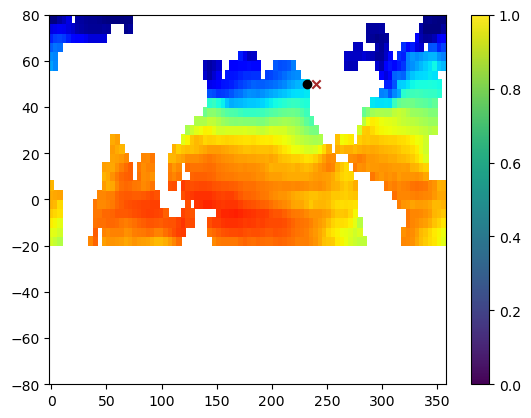

In [8]:
plt.pcolor(ds['XC'], ds['YC'], 
           ds['NaNmaskFinal']*ds['thetaSurf'].isel(time = 0), 
           cmap = 'jet', vmax = 35)
plt.scatter(240,50,marker = 'x', color = 'brown', label = "Objective function loc")
plt.scatter(232,50,marker = 'o', color = 'black', label = "Nearest wetpoint")
plt.colorbar()

In [52]:
cost = ds["thetaSurf"].sel(latitude=50.,longitude=232.)
    
wetpoints = np.nonzero(ds['maskFinal'].data)
thetaSurfWet = ds["thetaSurf"].data[:, wetpoints[0], wetpoints[1]]
saltSurfWet  = ds["saltSurf"].data[:, wetpoints[0], wetpoints[1]]
tauXWet      = ds["tauX"].data[:, wetpoints[0], wetpoints[1]]
tauYWet      = ds["tauY"].data[:, wetpoints[0], wetpoints[1]]
tauWet       = np.concatenate((tauXWet,tauYWet), axis = 1)

cost_seasonal = np.zeros((360,), dtype = float)
thetaSurf_seasonal = np.zeros((360, thetaSurfWet.shape[1]), dtype = float)

for i in range(360):
    cost_seasonal[i] = np.mean(cost[i:36000:360])
    thetaSurf_seasonal[i] = np.mean(thetaSurfWet[i:36000:360], axis = 0)

X = thetaSurfWet.copy()
y = cost.copy()

for i in range(X.shape[0]):
    X[i] = X[i] - thetaSurf_seasonal[i%360]
    y[i] = y[i] - cost_seasonal[i%360]

scipy.signal.detrend(X, axis=0, type='linear', bp=0, overwrite_data=True)
X = X - np.mean(X, axis = 0)

scipy.signal.detrend(y, axis=0, type='linear', bp=0, overwrite_data=True)
y = y - np.mean(y, axis = 0)

# https://stackoverflow.com/questions/13728392/moving-average-or-running-mean
y = np.convolve(y, np.ones(61)/61, mode='valid')
oneHotCost = np.zeros((y.shape[0], 2), dtype = int)
oneHotCost[:,0] = y >= 0.0
oneHotCost[:,1] = y <  0.0

np.sum(oneHotCost[:,0]), np.sum(oneHotCost[:,1])

(18052, 17888)

(array([ 437., 1076., 4695., 6323., 7258., 7753., 3277., 3760.,  994.,
         367.]),
 array([-1.08803075e-05, -8.60639095e-06, -6.33247441e-06, -4.05855787e-06,
        -1.78464133e-06,  4.89275203e-07,  2.76319174e-06,  5.03710828e-06,
         7.31102482e-06,  9.58494135e-06,  1.18588579e-05]),
 <BarContainer object of 10 artists>)

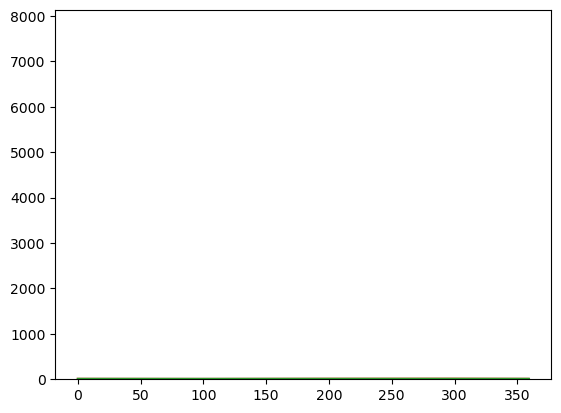

In [60]:
plt.plot(cost[:360])
plt.plot(cost_seasonal)
plt.plot(y[:360])

(array([ 437., 1076., 4695., 6323., 7258., 7753., 3277., 3760.,  994.,
         367.]),
 array([-1.08803075e-05, -8.60639095e-06, -6.33247441e-06, -4.05855787e-06,
        -1.78464133e-06,  4.89275203e-07,  2.76319174e-06,  5.03710828e-06,
         7.31102482e-06,  9.58494135e-06,  1.18588579e-05]),
 <BarContainer object of 10 artists>)

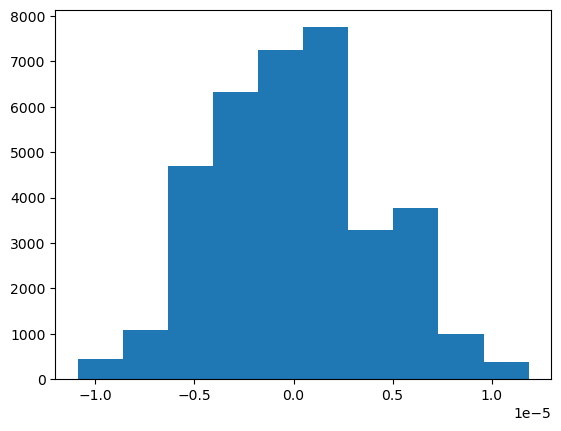

In [61]:
plt.hist(np.reshape(y, (-1,)), bins = 10)

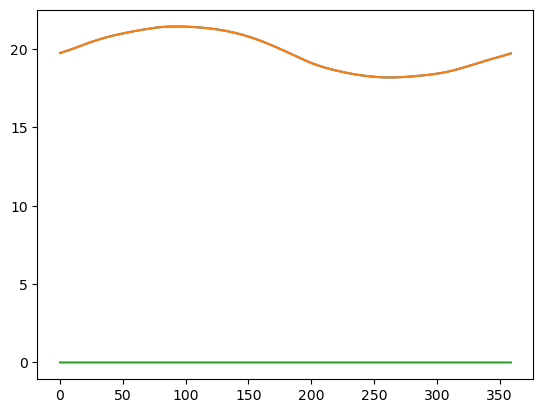

In [62]:
plt.plot(thetaSurfWet[:360,1])
plt.plot(thetaSurf_seasonal[:,1])
plt.plot(X[:360,1])

(array([1.6460000e+03, 1.6540000e+03, 2.5450000e+03, 6.2420000e+03,
        4.3779636e+07, 1.3618000e+04, 3.0150000e+03, 1.7040000e+03,
        1.6140000e+03, 3.2600000e+02]),
 array([-1.00892866, -0.78948697, -0.57004527, -0.35060357, -0.13116187,
         0.08827983,  0.30772153,  0.52716323,  0.74660493,  0.96604663,
         1.18548833]),
 <BarContainer object of 10 artists>)

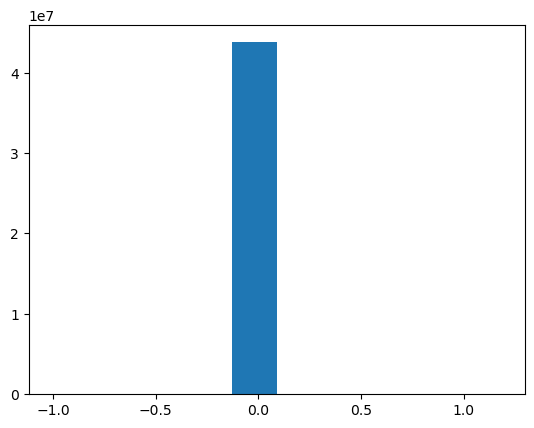

In [63]:
plt.hist(np.reshape(X, (-1,)), bins = 10)